In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI SDK for Python: AutoML training hierarchical forecasting for batch prediction

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/automl/sdk_automl_forecasting_hierarchical_batch.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/automl/sdk_automl_forecasting_hierarchical_batch.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/automl/sdk_automl_forecasting_hierarchical_batch.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview


This tutorial demonstrates how to use the Vertex AI SDK for Python to create hierarchical forecasting models using a Google Cloud [AutoML](https://cloud.google.com/vertex-ai/docs/start/automl-users)and do batch prediction.

### Dataset

The dataset used for this tutorial is the TODO dataset. In this dataset, you predict a fictional store's sales based on historical sales data.

### Objective

In this tutorial, you create an AutoML hierarchical forecasting model and deploy it for batch prediction using the Vertex AI SDK for Python. You can alternatively create and deploy models using the `gcloud` command-line tool or batch using the Cloud Console.

The steps performed include:

- Create a Vertex AI `TimeSeriesDataset` resource.
- Train the model.
- View the model evaluation.
- Deploy the `Model` resource to a serving `Endpoint` resource.
- Make a prediction.
- Undeploy the `Model`.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

If you are using Colab or Vertex AI Workbench, your environment already meets all the requirements to run this notebook. You can skip this step.

Otherwise, make sure your environment meets this notebook's requirements. You need the following:

- The Cloud Storage SDK
- Git
- Python 3
- virtualenv
- Jupyter notebook running in a virtual environment with Python 3

The Cloud Storage guide to [Setting up a Python development environment](https://cloud.google.com/python/setup) and the [Jupyter installation guide](https://jupyter.org/install) provide detailed instructions for meeting these requirements. The following steps provide a condensed set of instructions:

1. [Install and initialize the SDK](https://cloud.google.com/sdk/docs/).

2. [Install Python 3](https://cloud.google.com/python/setup#installing_python).

3. [Install virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv) and create a virtual environment that uses Python 3.  Activate the virtual environment.

4. To install Jupyter, run `pip3 install jupyter` on the command-line in a terminal shell.

5. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

6. Open this notebook in the Jupyter Notebook Dashboard.


## Installation

Install the latest version of the Vertex AI SDK for Python.

In [2]:
import os

# Google Cloud Notebook
if os.path.exists("/opt/deeplearning/metadata/env_version"):
    USER_FLAG = "--user"
else:
    USER_FLAG = ""

! pip3 install --upgrade google-cloud-aiplatform $USER_FLAG

You should consider upgrading via the '/Users/ivanmkc/Documents/code/vertex-ai-samples/env/bin/python -m pip install --upgrade pip' command.


Install the latest version of the scikit-learn for error calculations

In [ ]:
! pip3 install --upgrade google-cloud-aiplatform sklearn $USER_FLAG

Install the latest version of *google-cloud-storage*.

In [3]:
! pip3 install -U google-cloud-storage $USER_FLAG

You should consider upgrading via the '/Users/ivanmkc/Documents/code/vertex-ai-samples/env/bin/python -m pip install --upgrade pip' command.


Install the latest version of *google-cloud-bigquery*.

In [4]:
! pip3 install -U "google-cloud-bigquery[pandas]" $USER_FLAG

You should consider upgrading via the '/Users/ivanmkc/Documents/code/vertex-ai-samples/env/bin/python -m pip install --upgrade pip' command.


### Restart the kernel

After installing the packages, restart the notebook kernel.

In [5]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### GPU runtime

This tutorial does not require a GPU runtime.

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the following APIs: Vertex AI APIs, Compute Engine APIs, and Cloud Storage.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component,storage-component.googleapis.com)

4. If you are running this notebook locally, install the [Cloud SDK]((https://cloud.google.com/sdk)).

5. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$`.

In [18]:
PROJECT_ID = "python-docs-samples-tests"  # @param {type:"string"}

In [7]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "python-docs-samples-tests":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: python-docs-samples-tests


In [8]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations throughout the rest of this notebook. The following regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [28]:
REGION = "us-central1"  # @param {type: "string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, create a timestamp for each instance session, and append the timestamp onto the name of resources you create in this tutorial.

In [21]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using Google Cloud Notebooks**, your environment is already authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.

**Click Create service account**.

In the **Service account name** field, enter a name, and click **Create**.

In the **Grant this service account access to project** section, click the Role drop-down list. Type "Vertex" into the filter box, and select **Vertex Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

Click Create. A JSON file that contains your key downloads to your local environment.

Enter the path to your service account key as the GOOGLE_APPLICATION_CREDENTIALS variable in the cell below and run the cell.

In [11]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Google Cloud Notebook, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        ! gcloud auth login

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

A Cloud Storage bucket is needed for storing your data before passing it to Vertex AI for training.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

In [ ]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + TIMESTAMP
    BUCKET_URI = f"gs://{BUCKET_NAME}"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://python-docs-samples-testsaip-20220628183413/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_URI

### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [39]:
import google.cloud.aiplatform as aiplatform

## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and the corresponding bucket.

In [40]:
aiplatform.init(project=PROJECT_ID, location=REGION)

# Tutorial

Now you are ready to start creating your own AutoML tabular regression model.

### Create the Dataset

Use `TimeSeriesDataset.create()` to create a `TimeSeriesDataset` resource, which takes the following parameters:

- `display_name`: The human readable name for the `Dataset` resource.
- `gcs_source`: A list of one or more dataset index files to import the data items into the `Dataset` resource.
- `bq_source`: Alternatively, import data items from a BigQuery table into the `Dataset` resource.

This operation may take several minutes.

### Prepare data

Download the full sales data.

In [61]:
# TODO: Switch to a properly stored dataset
DATASET_URI = 'gs://ivanmkc-test2/sales_forecasting_full.csv'

# Download the dataset
! gsutil cp {DATASET_URI} dataset.csv

Copying gs://ivanmkc-test2/sales_forecasting_full.csv...
- [1 files][  1.6 MiB/  1.6 MiB]                                                
Operation completed over 1 objects/1.6 MiB.                                      


#### Split

Split the dataset into a train and test dataset.
The train dataset is saved to CSV but the test dataset needs further treatment.

In [314]:
import pandas as pd

DATASET_TRAIN_FILENAME = "sales_forecasting_train.csv"
DATASET_TEST_FILENAME = "sales_forecasting_test.csv"

# Load dataset
df = pd.read_csv("dataset.csv")

df['date'] = df['date'].astype("datetime64[ns]")

# Add a 
df['product_at_store'] = df['product'] + " (" + df['store'] + ")"

# Split dataset into train and test by taking the first 90% of data for training.
dates_unique = df['date'].unique()
date_cutoff = sorted(dates_unique)[round(len(dates_unique)*9/10)]

# Save train dataset
df[df['date'] < date_cutoff].to_csv(DATASET_TRAIN_FILENAME, index=False)

# Create test dataset
df_test = df[df['date'] >= date_cutoff]

# Upload to GCS bucket
! gsutil cp {DATASET_TRAIN_FILENAME} {DATASET_TRAIN_URI}

Copying file://sales_forecasting_train.csv [Content-Type=text/csv]...
/ [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      


Examine the columns in the dataset

In [315]:
df.columns

Index(['date_index', 'product_index', 'store_index', 'date', 'day_of_week',
       'temperature', 'product', 'product_type', 'product_category', 'store',
       'sales', 'product_at_store'],
      dtype='object')

In [66]:
dataset_time_series = aiplatform.TimeSeriesDataset.create(gcs_source=DATASET_TRAIN_URI)

print(dataset_time_series.resource_name)

Creating TimeSeriesDataset
Create TimeSeriesDataset backing LRO: projects/1012616486416/locations/us-central1/datasets/4441811471935995904/operations/3802097533673537536
TimeSeriesDataset created. Resource name: projects/1012616486416/locations/us-central1/datasets/4441811471935995904
To use this TimeSeriesDataset in another session:
ds = aiplatform.TimeSeriesDataset('projects/1012616486416/locations/us-central1/datasets/4441811471935995904')
projects/1012616486416/locations/us-central1/datasets/4441811471935995904


### Create and run training pipeline

To train an AutoML model, create and run a training pipeline.

#### Create training job

Create an AutoML training pipeline using the `AutoMLTabularTrainingJob` class, with the following parameters:

- `display_name`: The human readable name for the `TrainingJob` resource.
- `optimization_prediction_type`: The type task to train the model for.
  - `classification`: A tabular classification model.
  - `regression`: A tabular regression model.
- `column_transformations`: (Optional): Transformations to apply to the input columns
- `optimization_objective`: The optimization objective (minimize or maximize).
  - regression:
    - `minimize-rmse`
    - `minimize-mae`
    - `minimize-rmsle`

In [326]:
job = aiplatform.AutoMLForecastingTrainingJob(
    display_name="hierachical_sales_forecasting",
    optimization_objective="minimize-rmse",
    column_specs={
        "date": "timestamp",
        "sales": "numeric",
        "product_type": "categorical",
        "product_category": "categorical",
        "product": "categorical",
        "store": "categorical",
    },
)

print(job)

### Set context and horizon

You need to the context window and forecast horizon when you train a forecasting model.
- The context window sets how far back the model looks during training (and for forecasts). In other words, for each training datapoint, the context window determines how far back the model looks for predictive patterns.
- The forecast horizon determines how far into the future the model forecasts the target value for each row of prediction data.

See more here: [Considerations for setting the context window and forecast horizon](https://cloud.google.com/vertex-ai/docs/datasets/bp-tabular?hl=en#context-window)

In [ ]:
# Each row represents a day, so we set context and time horizon to 30 to represent 30 days.
 
CONTEXT_WINDOW = 30
TIME_HORIZON = 30

#### Run the training pipeline

Run the training job by invoking the `run` method with the following parameters:

- `dataset`: The `Dataset` resource to train the model.
- `model_display_name`: The human readable name for the trained model.
- `training_fraction_split`: The percentage of the dataset to use for training.
- `test_fraction_split`: The percentage of the dataset to use for test (holdout data).
- `validation_fraction_split`: The percentage of the dataset to use for validation.
- `target_column`: The name of the column to train as the label.
- `budget_milli_node_hours`: (optional) Maximum training time specified in unit of millihours (1000 = hour).
- `disable_early_stopping`: If `True`, training maybe completed before using the entire budget if the service believes it cannot further improve on the model objective measurements.

The `run` method when completed returns the `Model` resource.

The execution of the training pipeline will take upto 20 minutes.

In [68]:
time_column = "date"
time_series_identifier_column = "product_at_store"
target_column = "sales"

model = job.run(
    dataset=dataset_time_series,
    target_column=target_column,
    time_column=time_column,
    time_series_identifier_column=time_series_identifier_column,
    available_at_forecast_columns=[time_column],
    unavailable_at_forecast_columns=[target_column],
    time_series_attribute_columns=["product_type", "product_category", "store", "product"],
    forecast_horizon=TIME_HORIZON,
    data_granularity_unit="day",
    data_granularity_count=1,
    model_display_name="hierarchical_sales_forecasting_model",
    weight_column=None,
    # time_series_attribute_columns=_TEST_TRAINING_TIME_SERIES_ATTRIBUTE_COLUMNS,
    # context_window=_TEST_TRAINING_CONTEXT_WINDOW,
    # budget_milli_node_hours=_TEST_TRAINING_BUDGET_MILLI_NODE_HOURS,
    # export_evaluated_data_items=_TEST_TRAINING_EXPORT_EVALUATED_DATA_ITEMS,
    # export_evaluated_data_items_bigquery_destination_uri=_TEST_TRAINING_EXPORT_EVALUATED_DATA_ITEMS_BIGQUERY_DESTINATION_URI,
    # export_evaluated_data_items_override_destination=_TEST_TRAINING_EXPORT_EVALUATED_DATA_ITEMS_OVERRIDE_DESTINATION,
    # quantiles=_TEST_TRAINING_QUANTILES,
    # validation_options=_TEST_TRAINING_VALIDATION_OPTIONS,
    hierarchy_group_columns=["product_type", "product_category", "store", "product"],
    hierarchy_group_total_weight=10,
    # hierarchy_temporal_total_weight=_TEST_HIERARCHY_TEMPORAL_TOTAL_WEIGHT,
    # hierarchy_group_temporal_total_weight=_TEST_HIERARCHY_GROUP_TEMPORAL_TOTAL_WEIGHT,
    # window_column=_TEST_WINDOW_COLUMN,
    # window_stride_length=_TEST_WINDOW_STRIDE_LENGTH,
    # window_max_count=_TEST_WINDOW_MAX_COUNT,
)

No dataset split provided. The service will use a default split.
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5582902506305880064?project=1012616486416
AutoMLForecastingTrainingJob projects/1012616486416/locations/us-central1/trainingPipelines/5582902506305880064 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/1012616486416/locations/us-central1/trainingPipelines/5582902506305880064 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/1012616486416/locations/us-central1/trainingPipelines/5582902506305880064 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/1012616486416/locations/us-central1/trainingPipelines/5582902506305880064 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob run completed. Resource name: projects/1012616486416/locations/us-central1/trainingPipelines/5582902506305880064
Mode

## Review model evaluation scores
After your model has finished training, you can review its evaluation scores.

In [69]:
# Get evaluations
model_evaluations = model.list_model_evaluations()

model_evaluation = list(model_evaluations)[0]
print(model_evaluation)

resource name: projects/1012616486416/locations/us-central1/models/1000093786392494080@1/evaluations/3285342389653329310


## Send a batch prediction request

Now you can make a batch prediction.

### Prepare the test dataset

For forecasting, the test dataset needs to have context window rows which have information on the target column and subsequent time horizon rows where the target column is unknown. Construct these two sections and combine them into a single CSV file.

In [151]:
import numpy as np

# Store start and end dates for context and horizon
date_context_window_start = date_cutoff
date_context_window_end = date_cutoff + np.timedelta64(CONTEXT_WINDOW,'D')
time_horizon_end = date_context_window_end + np.timedelta64(TIME_HORIZON,'D')

# Extract dataframes for context and horizon
df_test_context = df_test[(df_test['date'] >= date_context_window_start) & (df_test['date'] < date_context_window_end)]
df_test_horizon = df_test[(df_test['date'] >= date_context_window_end) & (df_test['date'] < time_horizon_end)].copy()

# Save a copy for validation of predictions
df_test_horizon_actual = df_test_horizon.copy()

# Remove sales for horizon (i.e. future dates)
df_test_horizon['sales'] = ""

# Write test data to CSV
df_test = pd.concat([df_test_context, df_test_horizon])
df_test.to_csv(DATASET_TEST_FILENAME, index=False)

# Save test dataset
DATASET_TEST_URI = f"{BUCKET_URI}/{DATASET_TEST_FILENAME}"

# Upload to GCS bucket
! gsutil cp {DATASET_TEST_FILENAME} {DATASET_TEST_URI}

### Examine the context dataframe

Note that the sales column is filled.

In [323]:
df_test_context.head()

,date_index,product_index,store_index,date,day_of_week,temperature,product,product_type,product_category,store,sales,product_at_store
19740,658,0,0,2020-10-20,1,7.164706,Skis 1,Skis,Snow,Flagship,61.0,Skis 1 (Flagship)
19741,658,0,1,2020-10-20,1,7.164706,Skis 1,Skis,Snow,Suburbs,31.0,Skis 1 (Suburbs)
19742,658,0,2,2020-10-20,1,7.164706,Skis 1,Skis,Snow,Outskirts,15.0,Skis 1 (Outskirts)
19743,658,1,0,2020-10-20,1,7.164706,Skis 2,Skis,Snow,Flagship,61.0,Skis 2 (Flagship)
19744,658,1,1,2020-10-20,1,7.164706,Skis 2,Skis,Snow,Suburbs,28.0,Skis 2 (Suburbs)


### Examine the time horizon dataframe

Note that the sales column is empty.

In [325]:
df_test_horizon.head()

,date_index,product_index,store_index,date,day_of_week,temperature,product,product_type,product_category,store,sales,product_at_store
20640,688,0,0,2020-11-19,3,5.080392,Skis 1,Skis,Snow,Flagship,,Skis 1 (Flagship)
20641,688,0,1,2020-11-19,3,5.080392,Skis 1,Skis,Snow,Suburbs,,Skis 1 (Suburbs)
20642,688,0,2,2020-11-19,3,5.080392,Skis 1,Skis,Snow,Outskirts,,Skis 1 (Outskirts)
20643,688,1,0,2020-11-19,3,5.080392,Skis 2,Skis,Snow,Flagship,,Skis 2 (Flagship)
20644,688,1,1,2020-11-19,3,5.080392,Skis 2,Skis,Snow,Suburbs,,Skis 2 (Suburbs)


### Create a results dataset

Create a BigQuery dataset to store the prediction results.

In [73]:
from google.cloud import bigquery

# Create client in default region
bigquery_client = bigquery.Client(
    project=PROJECT_ID,
    credentials=aiplatform.initializer.global_config.credentials,
)

In [74]:
def create_bigquery_dataset(name: str, region: str):
    batch_predict_bq_output_uri_prefix = "bq://{}.{}".format(
        PROJECT_ID, name
    )
    
    bq_dataset = bigquery.Dataset("{}.{}".format(
        PROJECT_ID, name
    ))
    
    dataset_region = region
    bq_dataset.location = dataset_region
    bq_dataset = bigquery_client.create_dataset(bq_dataset)
    print(
        "Created bigquery dataset {} in {}".format(
            batch_predict_bq_output_uri_prefix, dataset_region
        )
    )
    
    return batch_predict_bq_output_uri_prefix

In [75]:
batch_predict_bq_output_uri_prefix = create_bigquery_dataset(name=f"hierarchical_forecasting_{TIMESTAMP}", region=REGION)

Created bigquery dataset bq://python-docs-samples-tests.hierarchical_forecasting_20220628183413 in us-central1


### Make the batch prediction request

You can make a batch prediction by invoking the batch_predict() method, with the following parameters:

- `job_display_name`: The human readable name for the batch prediction job.
- `gcs_source`: A list of one or more batch request input files.
- `gcs_destination_prefix`: The Cloud Storage location for storing the batch prediction resuls.
- `instances_format`: The format for the input instances, either 'bigquery', 'csv' or 'jsonl'. Defaults to 'jsonl'.
- `predictions_format`: The format for the output predictions, either 'csv' or 'jsonl'. Defaults to 'jsonl'.
- `machine_type`: The type of machine to use for training.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.
- `sync`: If set to True, the call will block while waiting for the asynchronous batch job to complete.

In [76]:
batch_prediction_job = model.batch_predict(
    job_display_name=f"hierarchical_forecasting_{TIMESTAMP}",
    gcs_source=DATASET_TEST_URI,
    instances_format="csv",
    bigquery_destination_prefix=batch_predict_bq_output_uri_prefix,
    predictions_format="bigquery",
    generate_explanation=True,
    sync=True,
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/1012616486416/locations/us-central1/batchPredictionJobs/1055263156705689600
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/1012616486416/locations/us-central1/batchPredictionJobs/1055263156705689600')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/1055263156705689600?project=1012616486416
BatchPredictionJob projects/1012616486416/locations/us-central1/batchPredictionJobs/1055263156705689600 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/1012616486416/locations/us-central1/batchPredictionJobs/1055263156705689600 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/1012616486416/locations/us-central1/batchPredictionJobs/1055263156705689600 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/1012616486416/locations/us-central1/batchPredicti

###  View the batch prediction results

Use the BigQuery Python client to query the destination table and return results as a Pandas dataframe.

In [77]:
# View the results as a dataframe
df_output = batch_prediction_job.iter_outputs(bq_max_results=1000).to_dataframe()

# Convert the dates to the datetime64 datatype
df_output['date'] = df_output['date'].astype('datetime64[ns]')

# Extract the predicted sales and convert to floats
df_output['predicted_sales'] = df_output['predicted_sales'].apply(lambda x: x['value']).astype(float)

df_output.head()

,date,explanation,predicted_on_date,predicted_sales,product,product_at_store,product_category,product_type,sales,store
0,2020-12-14,{'attributions': [{'featureAttributions': {'da...,2020-11-19,31.724567,Skis 1,Skis 1 (Suburbs),Snow,Skis,None,Suburbs
1,2020-11-19,{'attributions': [{'featureAttributions': {'da...,2020-11-19,34.611904,Skis 1,Skis 1 (Suburbs),Snow,Skis,None,Suburbs
2,2020-12-07,{'attributions': [{'featureAttributions': {'da...,2020-11-19,31.786795,Skis 1,Skis 1 (Suburbs),Snow,Skis,None,Suburbs
3,2020-11-21,{'attributions': [{'featureAttributions': {'da...,2020-11-19,44.332531,Skis 1,Skis 1 (Suburbs),Snow,Skis,None,Suburbs
4,2020-12-09,{'attributions': [{'featureAttributions': {'da...,2020-11-19,31.662598,Skis 1,Skis 1 (Suburbs),Snow,Skis,None,Suburbs


### Compare predictions vs ground truth

Plot the predicted sales vs the ground truth

<AxesSubplot:xlabel='date', ylabel='sales'>

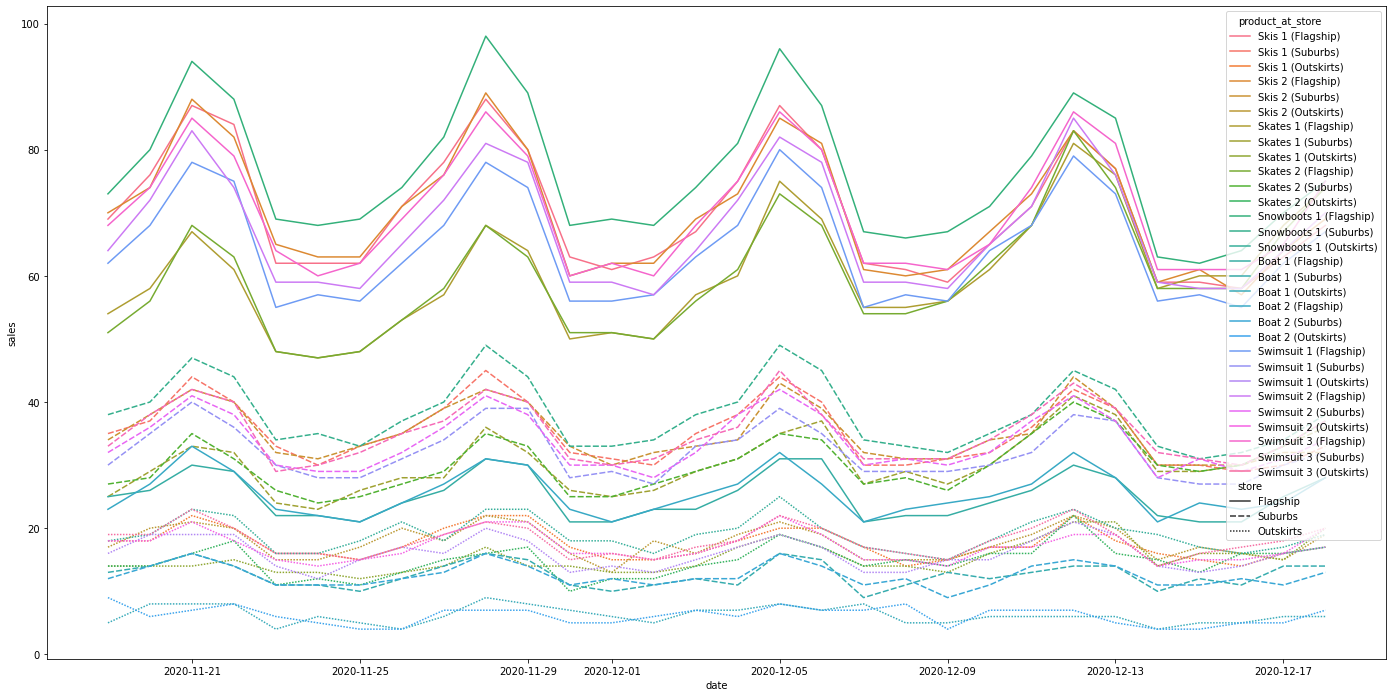

In [ ]:
# Plot sales
fig = plt.gcf()
fig.set_size_inches(24, 12)

sns.lineplot(data=df_test_horizon_actual,
    x="date", 
    y="sales", 
    hue="product_at_store",
    style="store")

<Figure size 1728x864 with 0 Axes>

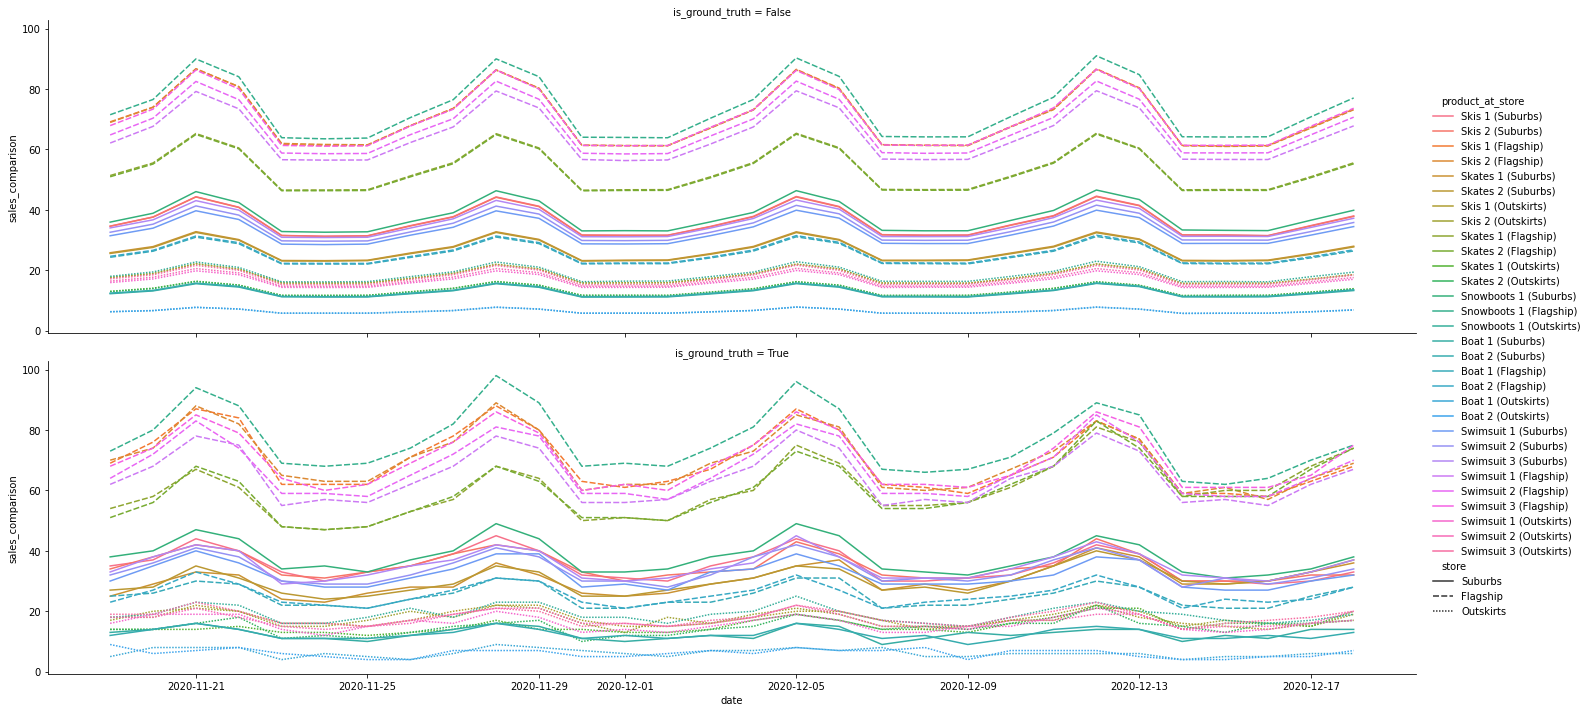

In [157]:
# Create a shared dataframe to plot predictions vs ground truth
df_output["sales_comparison"] = df_output["predicted_sales"]
df_output["is_ground_truth"] = False
df_test_horizon_actual["sales_comparison"] = df_test_horizon_actual["sales"]
df_test_horizon_actual["is_ground_truth"] = True
df_prediction_comparison = pd.concat([df_output, df_test_horizon_actual])

# Plot sales
fig = plt.gcf()
fig.set_size_inches(24, 12)

sns.relplot(
    data=df_prediction_comparison, 
    x="date", 
    y="sales_comparison", 
    hue="product_at_store",
    style="store",
    col="is_ground_truth",
    col_wrap=1,
    height=5, 
    aspect=4,
    kind="line",
    ci=None
)

In [187]:
df_prediction_error.columns

Index(['date', 'explanation', 'predicted_on_date', 'predicted_sales',
       'product_x', 'product_at_store', 'product_category_x', 'product_type_x',
       'sales_x', 'store_x', 'prediction_error', 'is_ground_truth_x',
       'sales_comparison', 'date_index', 'product_index', 'store_index',
       'day_of_week', 'temperature', 'product_y', 'product_type_y',
       'product_category_y', 'store_y', 'sales_y', 'is_ground_truth_y'],
      dtype='object')

### Calculate error

To understand how well the model did, calculate the error (RMSE) for the predictions

#### Calculate the error (RMSE) across predictions

In [223]:
from sklearn.metrics import mean_squared_error

# Merge the predicted and actual dataframes
df_prediction_error = pd.merge(left=df_output, right=df_test_horizon_actual, how="left", on=["date", "product_at_store"], suffixes=['', '_actual'])

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(df_prediction_error["sales_actual"], df_prediction_error["predicted_sales"]))

print(f"Root mean squared error: {rmse}")

Root mean squared error: 2.9639079637537207


#### Calculate the error (RMSE) across each product_at_store

In [307]:
# Create a new grouped dataframe for analysis
df_prediction_error_grouped = df_prediction_error.filter(["product_at_store", "product", "product_category", "product_type", "store", "predicted_sales", "sales_actual"]).groupby(["product_at_store"])
df_prediction_error_grouped_analysis = df_prediction_error_grouped.first().reset_index()

# Calculate the RMSE
df_prediction_error_grouped_analysis["rmse"] = list(df_prediction_error_grouped.apply(lambda rows: np.sqrt(mean_squared_error(rows["sales_actual"], rows["predicted_sales"]))))

# Show the RMSE per product_at_store
df_prediction_error_grouped_analysis.head()

,product_at_store,product,product_category,product_type,store,predicted_sales,sales_actual,rmse
0,Boat 1 (Flagship),Boat 1,Water,Boat,Flagship,31.080301,31.0,0.886801
1,Boat 1 (Outskirts),Boat 1,Water,Boat,Outskirts,6.155265,6.0,1.071323
2,Boat 1 (Suburbs),Boat 1,Water,Boat,Suburbs,12.183468,14.0,0.978489
3,Boat 2 (Flagship),Boat 2,Water,Boat,Flagship,26.701532,27.0,1.033497
4,Boat 2 (Outskirts),Boat 2,Water,Boat,Outskirts,6.287151,5.0,1.227470


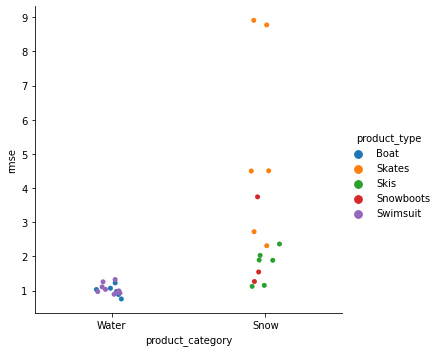

In [311]:
# Plot the RMSE with various stratifications
sns.catplot(data=df_prediction_error_grouped_analysis, x="product_category", y="rmse", hue="product_type")

It looks like the error is more problematic with Snow products and especially with skates.
This might be due to the higher variability with the sales of those products.
Further analysis will be left to the reader.

# Plot the error over time

<AxesSubplot:xlabel='date', ylabel='error'>

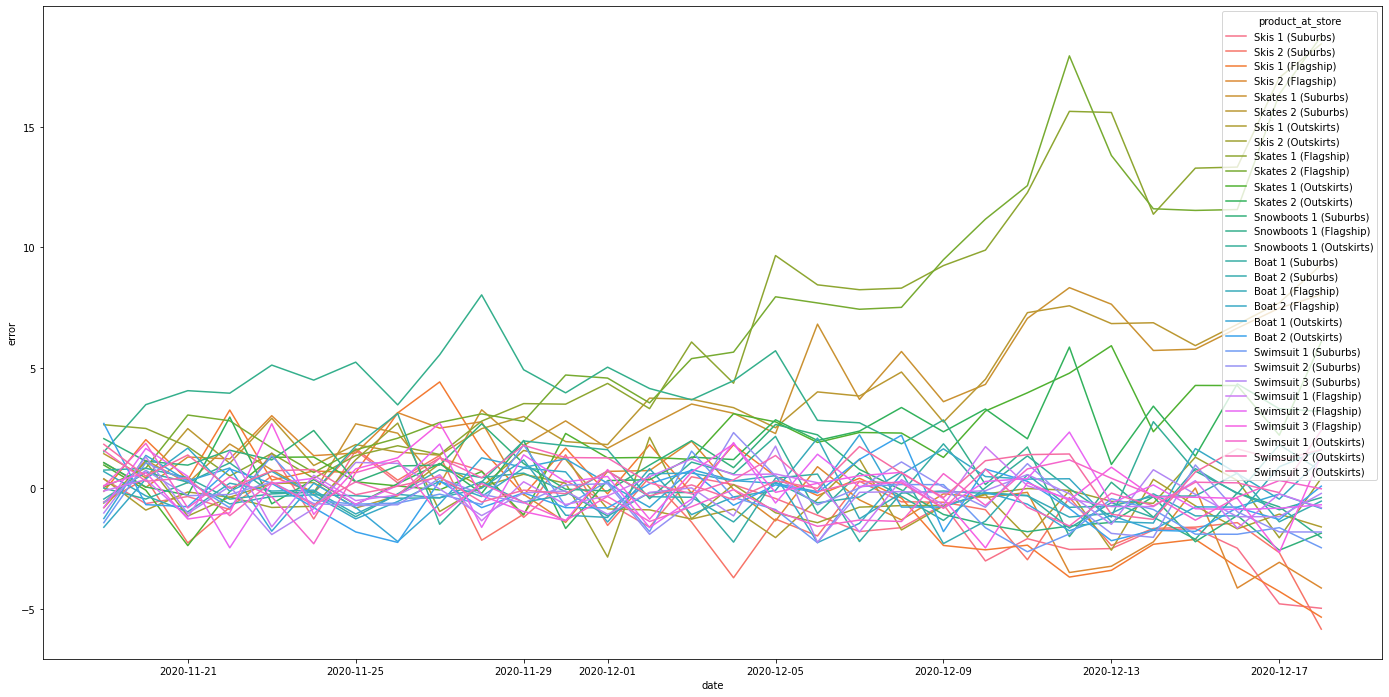

In [312]:
df_prediction_error["error"] = df_prediction_error["sales_actual"] - df_prediction_error["predicted_sales"]

# Plot error over time
fig = plt.gcf()
fig.set_size_inches(24, 12)

sns.lineplot(data=df_prediction_error, x="date", y="error", hue="product_at_store")

As expected, the error increases the further out you attempt to predict.

# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Model
- AutoML Training Job
- Batch Job
- Cloud Storage Bucket

In [ ]:
# Delete BigQuery datasets
bq_client.delete_dataset(
    f"{PROJECT_ID}.{TRAINING_INPUT_DATASET_ID}",
    delete_contents=True,
    not_found_ok=True,
)

bq_client.delete_dataset(
    f"{PROJECT_ID}.{PREDICTION_INPUT_DATASET_ID}",
    delete_contents=True,
    not_found_ok=True,
)

bq_client.delete_dataset(
    f"{PROJECT_ID}.{RESULTS_DATASET_ID}", delete_contents=True, not_found_ok=True
)

In [ ]:
# Delete Vertex AI resources
dataset.delete()
model.delete()
training_job.delete()
batch_predict_job.delete()